***Disease Prediction Using Machine Learning***

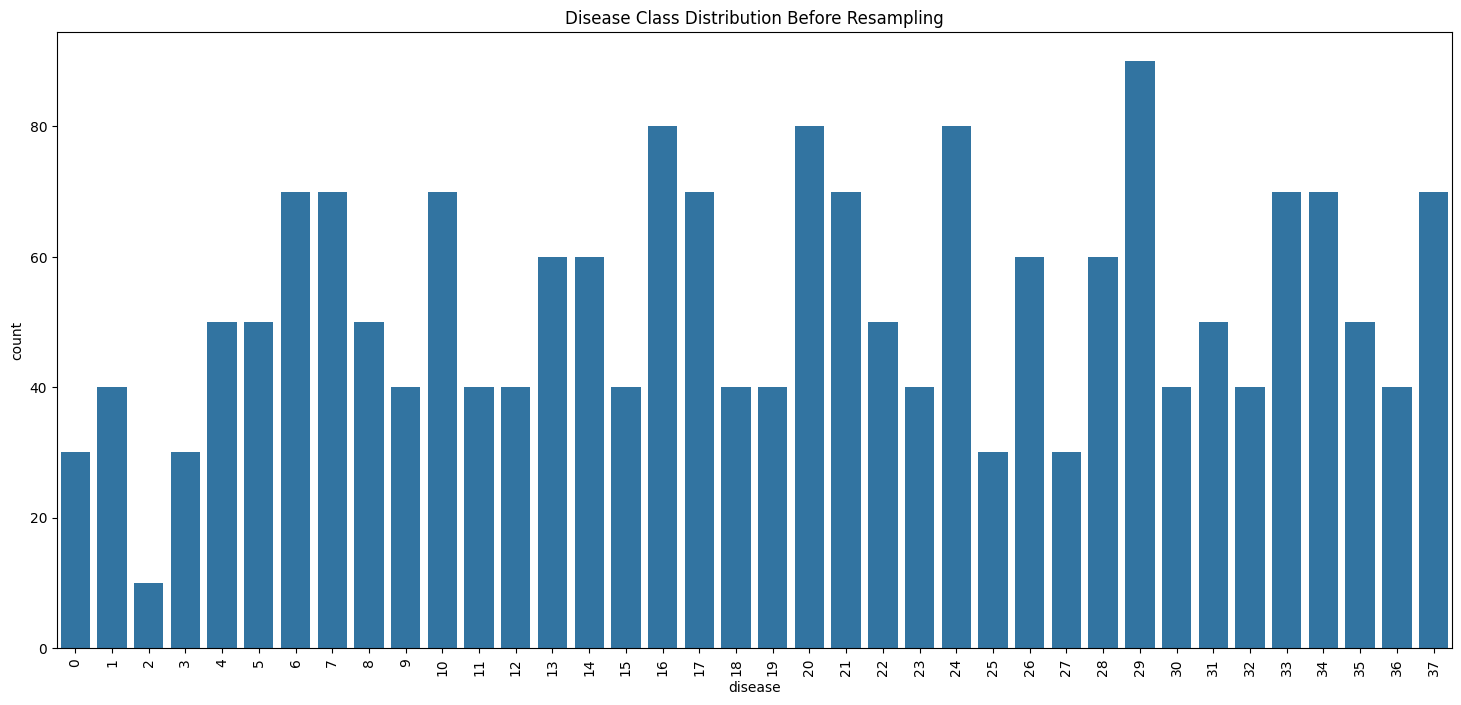

Resampled Class Distribution:
 disease
29    90
20    90
16    90
24    90
7     90
17    90
34    90
10    90
37    90
6     90
33    90
21    90
26    90
13    90
28    90
14    90
8     90
31    90
35    90
22    90
5     90
4     90
18    90
23    90
1     90
12    90
30    90
32    90
11    90
9     90
36    90
15    90
19    90
27    90
3     90
25    90
0     90
2     90
Name: count, dtype: int64


In [3]:
# Install imblearn if not already installed
!pip install imblearn

import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
# Import RandomOverSampler
from imblearn.over_sampling import RandomOverSampler

data = pd.read_csv('improved_disease_dataset.csv')

encoder = LabelEncoder()
data["disease"] = encoder.fit_transform(data["disease"])

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

plt.figure(figsize=(18, 8))
sns.countplot(x=y)
plt.title("Disease Class Distribution Before Resampling")
plt.xticks(rotation=90)
plt.show()

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("Resampled Class Distribution:\n", pd.Series(y_resampled).value_counts())

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold # Also need to import StratifiedKFold

if 'gender' in X_resampled.columns:
    le = LabelEncoder()
    X_resampled['gender'] = le.fit_transform(X_resampled['gender'])

X_resampled = X_resampled.fillna(0)

if len(y_resampled.shape) > 1:
    y_resampled = y_resampled.values.ravel()

models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

cv_scoring = 'accuracy'  # you can also use 'f1_weighted', 'roc_auc_ovr' for multi-class
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    try:
        scores = cross_val_score(
            model,
            X_resampled,
            y_resampled,
            cv=stratified_kfold,
            scoring=cv_scoring,
            n_jobs=-1,
            error_score='raise'
        )
        print("=" * 50)
        print(f"Model: {model_name}")
        print(f"Scores: {scores}")
        print(f"Mean Accuracy: {scores.mean():.4f}")
    except Exception as e:
        print("=" * 50)
        print(f"Model: {model_name} failed with error:")
        print(e)



Model: Decision Tree
Scores: [0.5497076  0.54385965 0.53508772 0.53654971 0.52631579]
Mean Accuracy: 0.5383
Model: Random Forest
Scores: [0.5745614  0.5497076  0.54239766 0.53070175 0.54385965]
Mean Accuracy: 0.5482


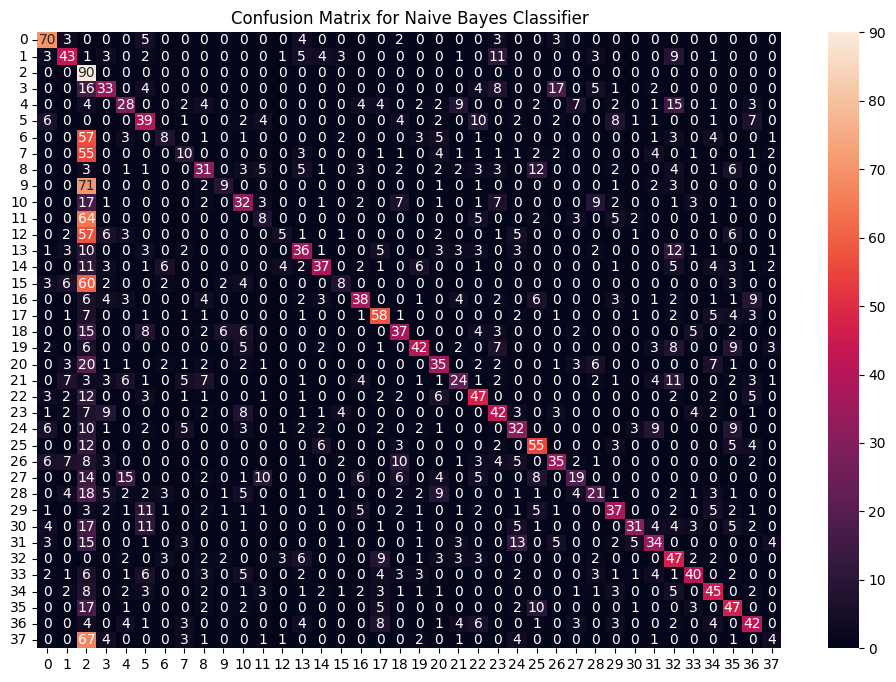

Naive Bayes Accuracy: 37.98%


In [6]:
nb_model = GaussianNB()
nb_model.fit(X_resampled, y_resampled)
nb_preds = nb_model.predict(X_resampled)

cf_matrix_nb = confusion_matrix(y_resampled, nb_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_nb, annot=True, fmt="d")
plt.title("Confusion Matrix for Naive Bayes Classifier")
plt.show()

print(f"Naive Bayes Accuracy: {accuracy_score(y_resampled, nb_preds) * 100:.2f}%")

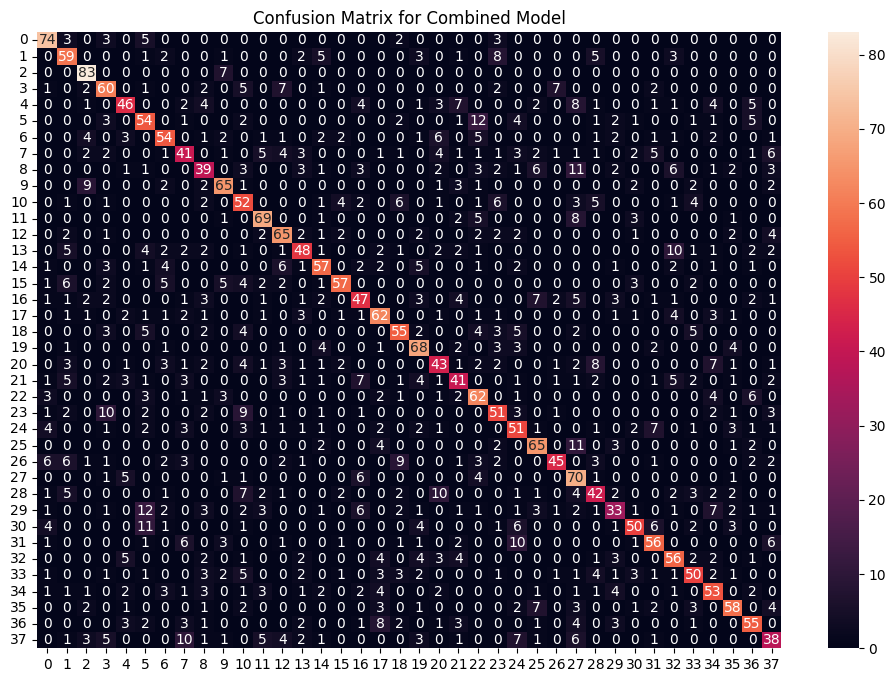

Combined Model Accuracy: 60.64%


In [9]:
from statistics import mode
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier # Ensure RandomForestClassifier is imported if not already

# Instantiate, train, and predict with the SVM model
svm_model = SVC()
svm_model.fit(X_resampled, y_resampled)
svm_preds = svm_model.predict(X_resampled)

# Instantiate, train, and predict with the Random Forest model
# We use the model instance created in the previous cell
rf_model = models["Random Forest"] # Get the RandomForestClassifier instance from the models dictionary
rf_model.fit(X_resampled, y_resampled) # Train the model
rf_preds = rf_model.predict(X_resampled) # Get predictions and store them in rf_preds

# Now svm_preds, nb_preds, and rf_preds are defined, and the rest of the code can execute
final_preds = [mode([i, j, k]) for i, j, k in zip(svm_preds, nb_preds, rf_preds)]

cf_matrix_combined = confusion_matrix(y_resampled, final_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_combined, annot=True, fmt="d")
plt.title("Confusion Matrix for Combined Model")
plt.show()

print(f"Combined Model Accuracy: {accuracy_score(y_resampled, final_preds) * 100:.2f}%")

In [11]:
symptoms = X.columns.values
symptom_index = {symptom: idx for idx, symptom in enumerate(symptoms)}

def predict_disease(input_symptoms):
    input_symptoms = input_symptoms.split(",")
    input_data = [0] * len(symptom_index)

    for symptom in input_symptoms:
        if symptom in symptom_index:
            input_data[symptom_index[symptom]] = 1

    input_data = np.array(input_data).reshape(1, -1)

    rf_pred = encoder.classes_[rf_model.predict(input_data)[0]]
    nb_pred = encoder.classes_[nb_model.predict(input_data)[0]]
    svm_pred = encoder.classes_[svm_model.predict(input_data)[0]]

    final_pred = mode([rf_pred, nb_pred, svm_pred])

    return {
        "Random Forest Prediction": rf_pred,
        "Naive Bayes Prediction": nb_pred,
        "SVM Prediction": svm_pred,
        "Final Prediction": final_pred
    }

print(predict_disease("Itching,Skin Rash,Nodal Skin Eruptions"))

{'Random Forest Prediction': 'Heart attack', 'Naive Bayes Prediction': 'Urinary tract infection', 'SVM Prediction': 'Impetigo', 'Final Prediction': 'Heart attack'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
